# TreeParzen and MLJ demo

In [1]:
import Gadfly, MLJBase, DataFrames, TreeParzen, MLJTuning, MLJModels, CategoricalArrays, ComputationalResources

In [2]:
# Helper function for tuning strings into not strings,
# seems to be required for use with XGBoostRegressor,
# Ints and other things make it complain
conv(x::CategoricalArrays.CategoricalArray) = Float64.(MLJBase.int(x))
conv(x) = Float64.(x)

conv (generic function with 2 methods)

In [3]:
#### constants ####
NUM_CV_FOLDS = 4
PCT_TRAIN_DATA = 0.75
NUM_TP_ITER_SMALL = 25
NUM_TP_ITER_LARGE = 250;

250

In [4]:
MLJBase.@load XGBoostRegressor

Features, targets = MLJBase.@load_reduced_ames
# This one turns strings into not strings, and everything into Float64s
IntCat_Features = NamedTuple{keys(Features)}(conv.(values(deepcopy(Features))))
Features = DataFrames.DataFrame(Features)
IntCat_Features = DataFrames.DataFrame(IntCat_Features);

In [5]:
# Do Hold-out partitioning. If you want same results each time use shuffle=false or set RNG seed
train, test = MLJBase.partition(eachindex(targets), PCT_TRAIN_DATA, shuffle=true)

train_features = IntCat_Features[train, :]
train_targets = targets[train]

test_features = IntCat_Features[test, :]
test_targets = targets[test]

num_train_data = length(train_targets)
training_data_per_fold = (num_train_data / NUM_CV_FOLDS) * (NUM_CV_FOLDS - 1)

819.0

Some prior decisions (almost arbitrary, there aren't strong reasons to make these decisions)
- Test holdout : 25%
- 4 fold cross validation -- this leaves each individual training set with ~820 data points and ~200 for evaluation on each fold
- Optimising using MAE as the metric because we will assess final quality on RMSL (and because for this example we're going to optimise directly in logspace)
We identified 7 potentially interesting optimisation parameters for gradient boosted trees.
One of the first things we note is that even if we just selected 2 points on the relevant ranges,
a cartesian product (grid search) over this space would be 128 evaluations
Search over 3 points on each axis (say, min, median, max) would take the search to well over 2000 evaluations.

In [6]:
space = Dict(
    :num_round => TreeParzen.HP.QuantUniform(:num_round, 1., 500., 1.),
    :eta => TreeParzen.HP.LogUniform(:eta, -3., 0.),
    :gamma => TreeParzen.HP.LogUniform(:gamma, -3., 3.),
    :max_depth => TreeParzen.HP.QuantUniform(:max_depth, 1., ceil(sqrt(training_data_per_fold)), 1.0),
    :min_child_weight => TreeParzen.HP.LogUniform(:min_child_weight, -5., 2.),
    :lambda => TreeParzen.HP.LogUniform(:lambda, -5., 2.),
    :alpha => TreeParzen.HP.LogUniform(:alpha, -5., 2.),
)

model_tpl = XGBoostRegressor()

XGBoostRegressor(
    num_round = 100,
    booster = "gbtree",
    disable_default_eval_metric = 0,
    eta = 0.3,
    gamma = 0.0,
    max_depth = 6,
    min_child_weight = 1.0,
    max_delta_step = 0.0,
    subsample = 1.0,
    colsample_bytree = 1.0,
    colsample_bylevel = 1.0,
    lambda = 1.0,
    alpha = 0.0,
    tree_method = "auto",
    sketch_eps = 0.03,
    scale_pos_weight = 1.0,
    updater = "auto",
    refresh_leaf = 1,
    process_type = "default",
    grow_policy = "depthwise",
    max_leaves = 0,
    max_bin = 256,
    predictor = "cpu_predictor",
    sample_type = "uniform",
    normalize_type = "tree",
    rate_drop = 0.0,
    one_drop = 0,
    skip_drop = 0.0,
    feature_selector = "cyclic",
    top_k = 0,
    tweedie_variance_power = 1.5,
    objective = "reg:linear",
    base_score = 0.5,
    eval_metric = "rmse",
    seed = 0) @ 3…26

Here we are tuning the model by MAE in logspace, which isn't necessarily right but we also need to ensure only positive valued outputs are produced. And this is easier for TreeParzen demonstration purposes than constructing a full learning network which log targets and exp predictions

In [7]:
tuning = MLJTuning.TunedModel(
    model=model_tpl,
    ranges=space,
    tuning=TreeParzen.MLJTreeParzen.MLJTreeParzenTuning(),
    n=NUM_TP_ITER_SMALL,
    resampling=MLJBase.CV(nfolds=NUM_CV_FOLDS),
    measure=MLJBase.mav,
)

mach = MLJBase.machine(tuning, train_features, log.(train_targets))
MLJBase.fit!(mach)

┌ Info: Training Machine{DeterministicTunedModel{MLJTreeParzenTuning,…}} @ 9…85.
└ @ MLJBase /Users/darenasc/.julia/packages/MLJBase/Cb9AY/src/machines.jl:187
┌ Info: Attempting to evaluate 25 models.
└ @ MLJTuning /Users/darenasc/.julia/packages/MLJTuning/JZ7ZX/src/tuned_models.jl:501
Evaluating over 20 metamodels: 100%[=========================] Time: 0:00:46
Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:08
Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:09
Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:07
Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:07
Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:09


Machine{DeterministicTunedModel{MLJTreeParzenTuning,…}} @ 9…85


perform the evaluation(s) -- predict for a TunedModel will use best one (or best parameters trained on whole data, depending on settings)

In [8]:
pred = exp.(MLJBase.predict(mach, test_features))
@show MLJBase.rmsl(test_targets, pred)

best_model = MLJBase.fitted_params(mach).best_model

for x in keys(space) println("$x = $(getproperty(best_model, x))") end

metric = first.(getfield.(getfield.(mach.report.history, 2), :measurement))
cummetric = accumulate(min, metric);

MLJBase.rmsl(test_targets, pred) = 0.13256110382362607
lambda = 0.0415647269405596
alpha = 0.04449417692469611
gamma = 0.0571727166898479
min_child_weight = 0.03826207565847638
eta = 0.11778741582986124
num_round = 358
max_depth = 26


25-element Array{Float64,1}:
 0.11832597033923721
 0.1172168683191494 
 0.10952707816081192
 0.10952707816081192
 0.10952707816081192
 0.10952707816081192
 0.10952707816081192
 0.10952707816081192
 0.10952707816081192
 0.10952707816081192
 0.10952707816081192
 0.10952707816081192
 0.10952707816081192
 0.10952707816081192
 0.10952707816081192
 0.10952707816081192
 0.10952707816081192
 0.10952707816081192
 0.10952707816081192
 0.10952707816081192
 0.10612857011795974
 0.10347682583081969
 0.10347682583081969
 0.10288353730419823
 0.10288353730419823

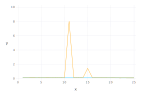

In [9]:
Gadfly.plot(Gadfly.layer(x=1:length(metric), y=metric, Gadfly.Geom.line, Gadfly.Theme(default_color=Gadfly.colorant"orange")), Gadfly.layer(x=1:length(metric), y=cummetric, Gadfly.Geom.step))

To demonstrate use of suggestions, we can take the best result from last tuning run.

BEAR IN MIND that this is cheating from a data science perspective, this is just to demonstrate the functionality.

In [10]:
suggestion = Dict(key => getproperty(best_model, key) for key in keys(space))

search = TreeParzen.MLJTreeParzen.MLJTreeParzenSpace(space, suggestion)

tuning = MLJTuning.TunedModel(
    model=model_tpl,
    ranges=space,
    tuning=TreeParzen.MLJTreeParzen.MLJTreeParzenTuning(;random_trials=3),
    n=NUM_TP_ITER_SMALL,
    resampling=MLJBase.CV(nfolds=NUM_CV_FOLDS),
    measure=MLJBase.mav,
)

mach = MLJBase.machine(tuning, train_features, log.(train_targets))
MLJBase.fit!(mach)

┌ Info: Training Machine{DeterministicTunedModel{MLJTreeParzenTuning,…}} @ 1…55.
└ @ MLJBase /Users/darenasc/.julia/packages/MLJBase/Cb9AY/src/machines.jl:187
┌ Info: Attempting to evaluate 25 models.
└ @ MLJTuning /Users/darenasc/.julia/packages/MLJTuning/JZ7ZX/src/tuned_models.jl:501
Evaluating over 3 metamodels: 100%[=========================] Time: 0:00:10
Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:01
Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:00
Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:01
Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:00
Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:05
Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:01
Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:02
Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:00
Evaluating over 1 metamodels:

Machine{DeterministicTunedModel{MLJTreeParzenTuning,…}} @ 1…55


perform the evaluation(s) -- predict for a TunedModel will use best one (or best parameters trained on whole data, depending on settings)

In [11]:
pred = exp.(MLJBase.predict(mach, test_features))
@show MLJBase.rmsl(test_targets, pred)

best_model = MLJBase.fitted_params(mach).best_model

for x in keys(space) println("$x = $(getproperty(best_model, x))") end

MLJBase.rmsl(test_targets, pred) = 0.1323507073457361
lambda = 0.15458488889247793
alpha = 0.23655437635964927
gamma = 0.050920609872212606
min_child_weight = 0.2210302672639424
eta = 0.1054445523374541
num_round = 344
max_depth = 17


We can also accelerate learning by using parallelism
notice how above we had 20 metamodels followed by sequences of 1?

What is happening here is that there is an initial stage (by default 20)
of models drawn entirely at random (using specified prior distributions)
without probabilistic modelling. Once probabilistic modelling kicks in,
we draw a suggestion and then update with result. This doesn't seem amenable
to parallelism, and it isn't. However there is an additional parameter
`max_simultaneous_draws` which allows the system to draw `n` samples before
`updating` the distribution. Whilst intuitively this allows parallelism, it
also enables more exploration before drawing again according to updated distribution.

If using this parameter, consider increasing the value of `linear_forgetting`
from its default of 25 to a higher number -- a good place is probably at least `n*25`. The
`linear_forgetting` parameter keeps most n recently observed results equally weighted
and older observations are  weighted by a linear ramp according to their age.

In [12]:
# grab previous best result again, hey we started cheating, might as well continue.
suggestion = Dict(key => getproperty(best_model, key) for key in keys(space))
search = TreeParzen.MLJTreeParzen.MLJTreeParzenSpace(space, suggestion)

tuning = MLJTuning.TunedModel(
    model=model_tpl,
    ranges=space,
    tuning=TreeParzen.MLJTreeParzen.MLJTreeParzenTuning(;random_trials=3, max_simultaneous_draws=2, linear_forgetting=50),
    n=NUM_TP_ITER_SMALL,
    resampling=MLJBase.CV(nfolds=NUM_CV_FOLDS),
    measure=MLJBase.mav,
)

mach = MLJBase.machine(tuning, train_features, log.(train_targets))
MLJBase.fit!(mach)

┌ Info: Training Machine{DeterministicTunedModel{MLJTreeParzenTuning,…}} @ 4…74.
└ @ MLJBase /Users/darenasc/.julia/packages/MLJBase/Cb9AY/src/machines.jl:187
┌ Info: Attempting to evaluate 25 models.
└ @ MLJTuning /Users/darenasc/.julia/packages/MLJTuning/JZ7ZX/src/tuned_models.jl:501
Evaluating over 3 metamodels: 100%[=========================] Time: 0:00:02
Evaluating over 2 metamodels: 100%[=========================] Time: 0:00:03
Evaluating over 2 metamodels: 100%[=========================] Time: 0:00:03
Evaluating over 2 metamodels: 100%[=========================] Time: 0:00:07
Evaluating over 2 metamodels: 100%[=========================] Time: 0:00:04
Evaluating over 2 metamodels: 100%[=========================] Time: 0:00:04
Evaluating over 2 metamodels: 100%[=========================] Time: 0:00:17
Evaluating over 2 metamodels: 100%[=========================] Time: 0:00:15
Evaluating over 2 metamodels: 100%[=========================] Time: 0:00:04
Evaluating over 2 metamodels:

Machine{DeterministicTunedModel{MLJTreeParzenTuning,…}} @ 4…74


It's worth noting, that this changed behaviour of optimiser but didn't
introduce parallelism directly: That's up to MLJ. So lets parallelise.
It wouldn't really accelerate computations in this case possibly due to
overheads, but is an option for larger tasks. Also note that we can instead
parallelise via `resampling_acceleration` if we don't want to alter behaviour of
optimiser, but this might be more limited.

In [13]:
suggestion = Dict(key => getproperty(best_model, key) for key in keys(space))
search = TreeParzen.MLJTreeParzen.MLJTreeParzenSpace(space, suggestion)

tuning = MLJTuning.TunedModel(
    model=model_tpl,
    ranges=space,
    tuning=TreeParzen.MLJTreeParzen.MLJTreeParzenTuning(;random_trials=3, max_simultaneous_draws=2, linear_forgetting=50),
    n=NUM_TP_ITER_SMALL,
    resampling=MLJBase.CV(nfolds=NUM_CV_FOLDS),
    measure=MLJBase.mav,
    acceleration=ComputationalResources.CPUProcesses(),
)

mach = MLJBase.machine(tuning, train_features, log.(train_targets))
MLJBase.fit!(mach)

┌ Info: Training Machine{DeterministicTunedModel{MLJTreeParzenTuning,…}} @ 8…65.
└ @ MLJBase /Users/darenasc/.julia/packages/MLJBase/Cb9AY/src/machines.jl:187
┌ Info: Attempting to evaluate 25 models.
└ @ MLJTuning /Users/darenasc/.julia/packages/MLJTuning/JZ7ZX/src/tuned_models.jl:501
Evaluating over 3 metamodels: 100%[=========================] Time: 0:00:13
Evaluating over 2 metamodels: 100%[=========================] Time: 0:00:02
Evaluating over 2 metamodels: 100%[=========================] Time: 0:00:18
Evaluating over 2 metamodels: 100%[=========================] Time: 0:00:01
Evaluating over 2 metamodels: 100%[=========================] Time: 0:00:05
Evaluating over 2 metamodels: 100%[=========================] Time: 0:00:02
Evaluating over 2 metamodels: 100%[=========================] Time: 0:00:02
Evaluating over 2 metamodels: 100%[=========================] Time: 0:00:03
Evaluating over 2 metamodels: 100%[=========================] Time: 0:00:09
Evaluating over 2 metamodels:

Machine{DeterministicTunedModel{MLJTreeParzenTuning,…}} @ 8…65


An interesting feature of note is that TreeParzen supports "tree-structured"
parameter spaces; hence the name. Originally conceived for optimising
Deep Belief Networks (DBNs), where parameters take form such as number of layers,
and how many nodes are within each layer. Here, we can see the idea that if
we have 2 layers, then number of nodes in layer 3 as a parameter is not relevant.
We can construct a similar example using XGBoost - either we can use boosted trees
or boosted linears. Some parameters are relevant in both cases, but even so we
would want to model them differently, e.g. `num_iterations` might need to be lower for
boosting trees than for boosting linear functions.

In [14]:
# First, create a container model (because of space nesting, we need to do this)
# plus its constructor:
mutable struct tuned_xgb <: MLJBase.Deterministic
    xgb::XGBoostRegressor
end
tuned_xgb(;xgb=Dict{Symbol, Any}()) = tuned_xgb(XGBoostRegressor(;xgb...))

# quick fit and predict methods
MLJBase.fit(t::tuned_xgb, verbosity::Int, X, y, w=nothing) = MLJBase.fit(t.xgb, verbosity, X, y, w)
MLJBase.predict(t::tuned_xgb, fitted, X) = MLJBase.predict(t.xgb, fitted, X)

# Define search parameters for the tree search space
tree_space = Dict(
    :booster => "gbtree",
    :num_round => TreeParzen.HP.QuantUniform(:num_round_tree, 1., 500., 1.),
    :eta => TreeParzen.HP.LogUniform(:eta_tree, -3., 0.),
    :gamma => TreeParzen.HP.LogUniform(:gamma_tree, -3., 3.),
    :max_depth => TreeParzen.HP.QuantUniform(:max_depth_tree, 1., ceil(sqrt(training_data_per_fold)), 1.0),
    :min_child_weight => TreeParzen.HP.LogUniform(:min_child_weight_tree, -5., 2.),
    :lambda => TreeParzen.HP.LogUniform(:lambda_tree, -5., 2.),
    :alpha => TreeParzen.HP.LogUniform(:alpha_tree, -5., 2.),
)

# Define search parameters for the linear search space
linear_space = Dict(
    :booster => "gblinear",
    :updater => "coord_descent",
    :num_round => TreeParzen.HP.QuantUniform(:num_round_linear, 500., 1000., 1.),
    :lambda => TreeParzen.HP.LogUniform(:lambda_linear, -10., 0.),
    :alpha => TreeParzen.HP.LogUniform(:alpha_linear, -10., 0.),
    :feature_selector => TreeParzen.HP.Choice(:feature_selector_linear, ["cyclic", "greedy"]),
)

# Now we combine them so that it chooses either one search space or another (and then select parameters for each)
joint_space = Dict(
    :xgb => TreeParzen.HP.Choice(:xgb, [linear_space, tree_space])
)


# Because we have a top level conditional, crank up the number of random trials to start off with
tuning = MLJTuning.TunedModel(
    model=tuned_xgb(),
    ranges=joint_space,
    tuning=TreeParzen.MLJTreeParzen.MLJTreeParzenTuning(;random_trials=50),
    n=NUM_TP_ITER_LARGE,
    resampling=MLJBase.CV(nfolds=NUM_CV_FOLDS),
    measures=MLJBase.mav,
)

# Do the usual fitting
mach = MLJBase.machine(tuning, train_features, log.(train_targets))
MLJBase.fit!(mach)

┌ Info: Training Machine{DeterministicTunedModel{MLJTreeParzenTuning,…}} @ 8…51.
└ @ MLJBase /Users/darenasc/.julia/packages/MLJBase/Cb9AY/src/machines.jl:187
┌ Info: Attempting to evaluate 250 models.
└ @ MLJTuning /Users/darenasc/.julia/packages/MLJTuning/JZ7ZX/src/tuned_models.jl:501
Evaluating over 50 metamodels: 100%[=========================] Time: 0:02:18
Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:00
Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:01
Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:01
Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:00
Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:01
Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:00
Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:00
Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:01
Evaluating over 1 metamodel

Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:00
Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:01
Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:00
Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:00
Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:01
Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:01
Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:01
Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:00
Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:01
Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:01
Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:01
Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:01
Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:01
Evaluating o

Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:00
Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:00
Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:01
Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:01
Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:00
Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:01
Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:00
Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:01
Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:01
Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:01
Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:01
Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:01
Evaluating over 1 metamodels: 100%[=========================] Time: 0:00:01
Evaluating o

Machine{DeterministicTunedModel{MLJTreeParzenTuning,…}} @ 8…51


In [15]:
# Print out final evaluation, but we dont know what the best model is yet
pred = exp.(MLJBase.predict(mach, test_features))
@show MLJBase.rmsl(test_targets, pred)

MLJBase.rmsl(test_targets, pred) = 0.1345730903112504


0.1345730903112504

In [16]:
# Take a look at the best performing model
best_model = MLJBase.fitted_params(mach).best_model.xgb
if best_model.booster == "gbtree"
    println("Tree params")
    for x in keys(tree_space) println("$x = $(getproperty(best_model, x))") end
else
    println("Linear params")
    for x in keys(linear_space) println("$x = $(getproperty(best_model, x))") end
end

Linear params
lambda = 0.0010837649747430396
alpha = 0.013896985340684417
feature_selector = cyclic
num_round = 973
booster = gblinear
updater = coord_descent


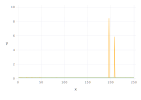

In [17]:
# Look at learning history (linear isn't very good so large spikes probably correspond with the times it selects linear learner)
metric = first.(getfield.(getfield.(mach.report.history, 2), :measurement))
cummetric = accumulate(min, metric)
Gadfly.plot(Gadfly.layer(x=1:length(metric), y=metric, Gadfly.Geom.line, Gadfly.Theme(default_color=Gadfly.colorant"orange")), Gadfly.layer(x=1:length(metric), y=cummetric, Gadfly.Geom.step))